# Data Description
These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results The date in yyyy-mm-dd format The local time of day in hh:mm:ss 24-hour format The numeric data, if any (may be an empty string) The text data, if any (may be an empty string)

The units of each dataset are:  

Solar radiation: watts per meter^2  
Temperature: degrees Fahrenheit  
Humidity: percent  
Barometric pressure: Hg  
Wind direction: degrees  
Wind speed: miles per hour  
Sunrise/sunset: Hawaii time  
link: https://www.kaggle.com/datasets/dronio/SolarEnergy


# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

from tensorflow.keras.layers import Dense,Dropout,Activation # type: ignore
from tensorflow.keras.optimizers import SGD,Adam # type: ignore
from tensorflow.keras.models import Sequential # type: ignore

from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [3]:
data=pd.read_csv('SolarPrediction.csv')

In [4]:
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [6]:
df=data.copy()

In [7]:
st="9/29/2016 12:00:00 AM"
st.split()

['9/29/2016', '12:00:00', 'AM']

In [8]:
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [9]:
df['Month']=pd.to_datetime(df['Data']).dt.month

In [10]:
df['Day']=pd.to_datetime(df['Data']).dt.day

df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [11]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,0,20,4
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,0,15,1
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,0,10,1
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,0,5,2


In [12]:
# '^\d' means that I don't want any digit ('^' this symbol means 'not')
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [13]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  Day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [15]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [16]:
df.shape

(32686, 15)

In [17]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminuter               0
sethour                   0
setminute                 0
dtype: int64

In [18]:
input_features=df.drop(['Radiation'],axis=1)
target=df['Radiation']

### Feature Selection using correlation matrix


In [19]:
corr_matrix=df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


<Axes: >

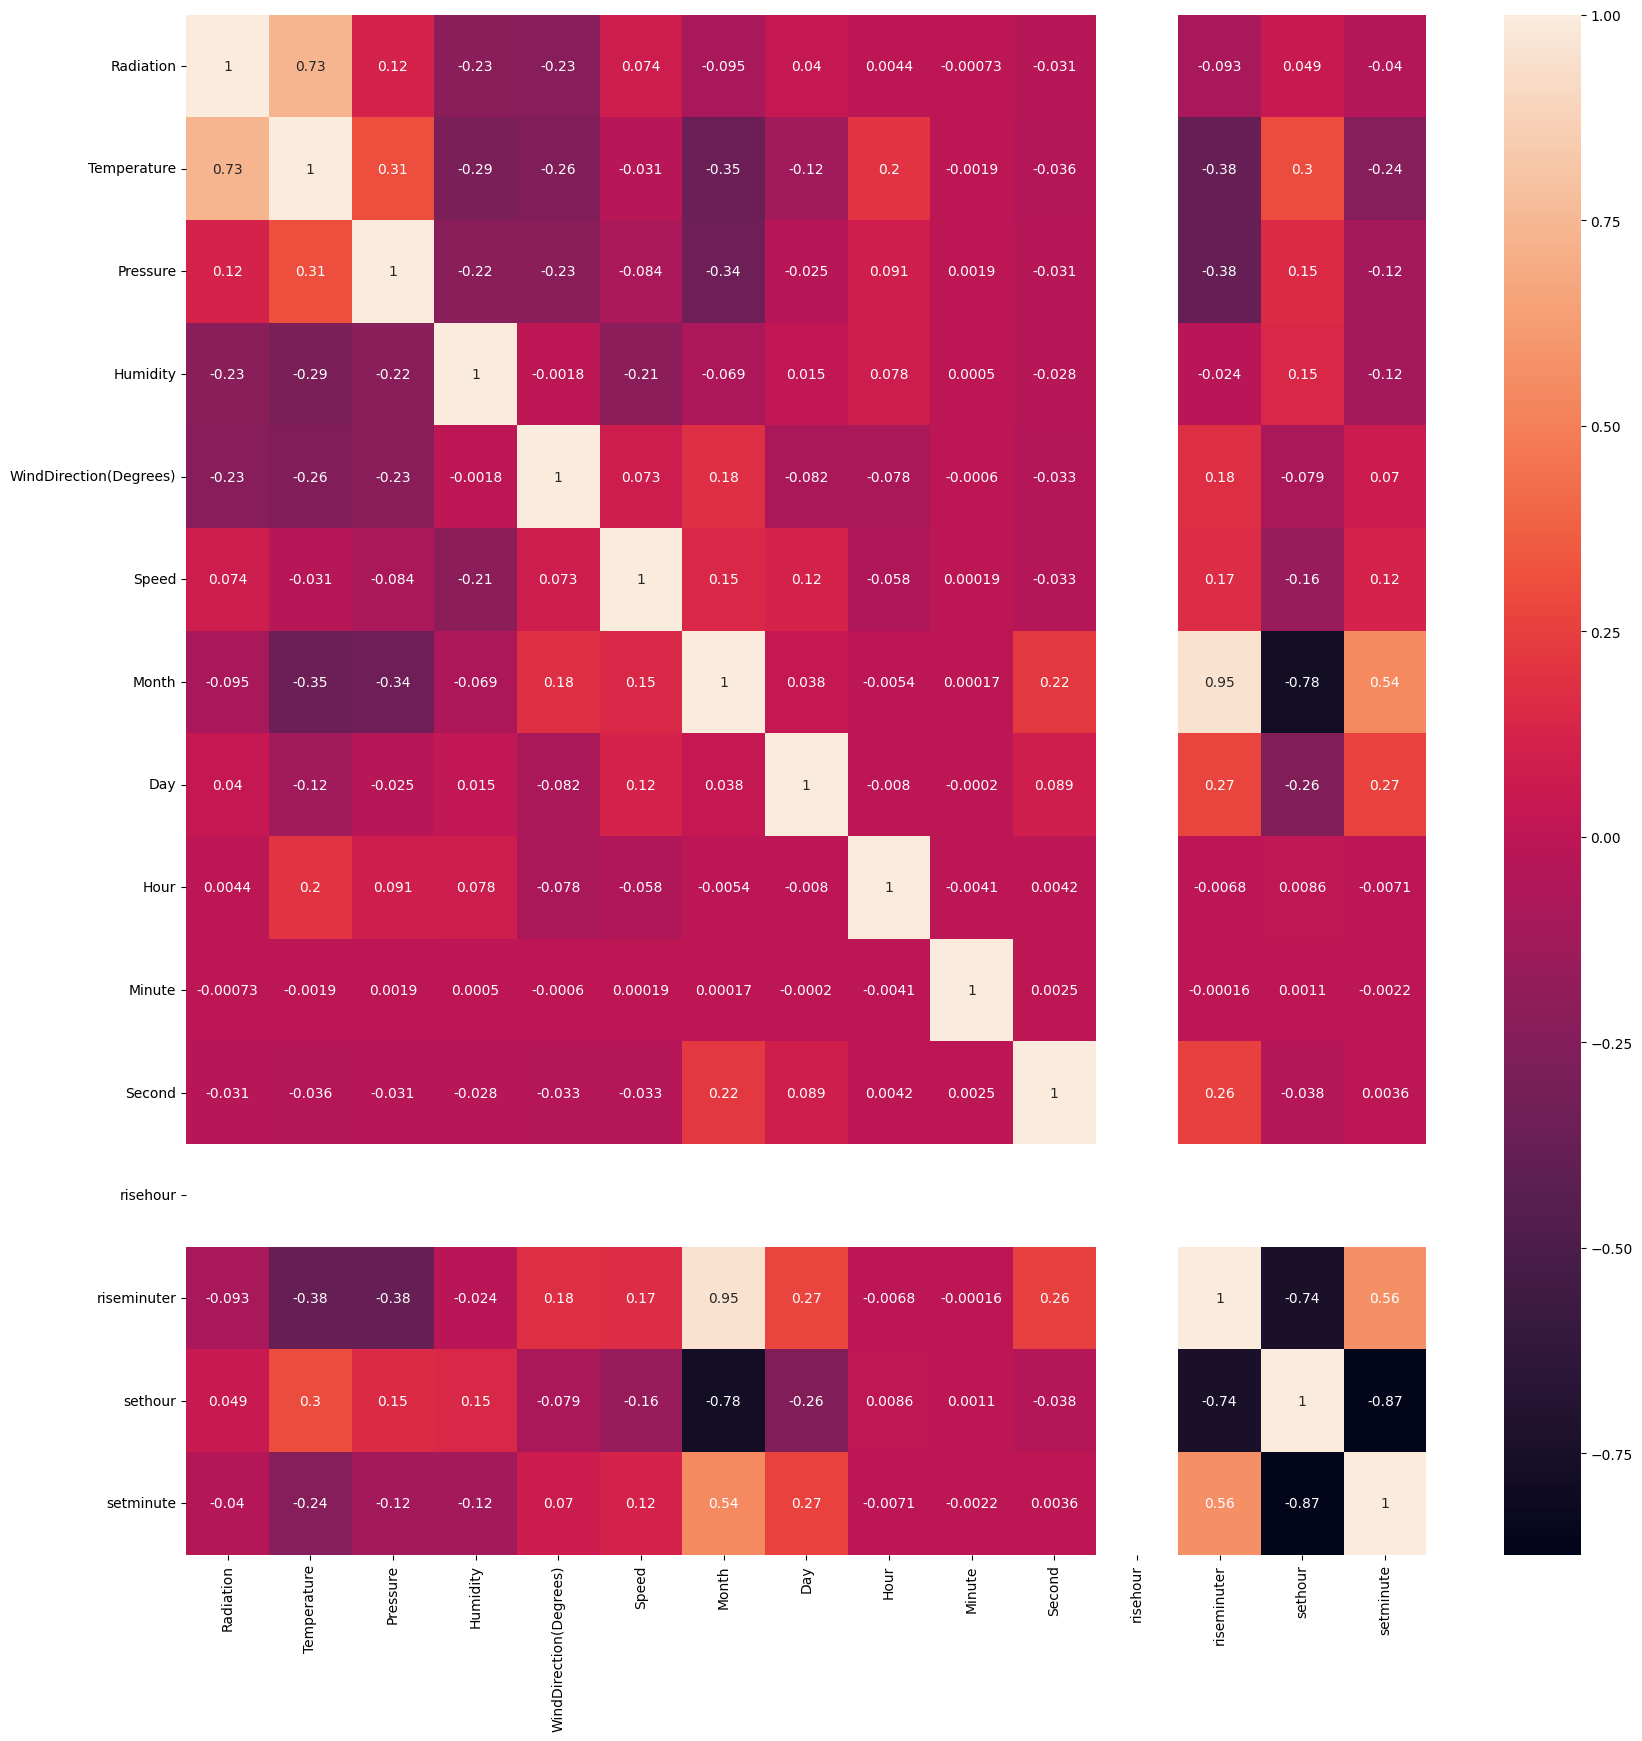

In [20]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,annot=True)

### Feature selection using SelectKBest Meathod

In [21]:
bestfeatures=SelectKBest(score_func=chi2,k=10)

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_y=label_encoder.fit_transform(target)

In [23]:
train_y

array([ 9,  9, 11, ...,  8, 11,  8], shape=(32686,))

In [24]:
target_cont=df['Radiation'].apply(lambda x: int(x*100))

In [25]:
scaled_input_features=MinMaxScaler().fit_transform(input_features)
fit=bestfeatures.fit(scaled_input_features,target_cont)

In [26]:
fit.scores_

array([ 1651.68563214,   523.79106046,  1588.08743322,  3271.82727734,
         765.85977881,  4684.57961042,  2841.92685032,   691.18539264,
        2702.44933263,  2288.67303161,            nan,  4015.06277087,
       12207.53145397,  1863.71208749])

In [27]:
scores=pd.DataFrame(fit.scores_)
column=pd.DataFrame(input_features.columns)

In [28]:
featureScores=pd.concat([column,scores],axis=1)
featureScores.columns=['Features','feature_imp']

In [29]:
featureScores.sort_values(by='feature_imp',ascending=False)

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


# Feature Selection using Using Extra Tree Classifier

In [30]:
model=ExtraTreesClassifier(n_estimators=2,verbose=2)
model.fit(scaled_input_features,target_cont)

building tree 1 of 2
building tree 2 of 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.2s finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",2
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=FalseWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",False
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [31]:
feature_importances=pd.DataFrame(model.feature_importances_,index=input_features.columns,columns=['feature_imp'])
feature_importances.sort_values(by='feature_imp',ascending=False,inplace=True)
feature_importances

,feature_imp
WindDirection(Degrees),0.160225
Minute,0.153261
Speed,0.127991
Second,0.127763
Humidity,0.109205
Hour,0.082133
Temperature,0.081016
Pressure,0.071759
Day,0.034130
setminute,0.024810


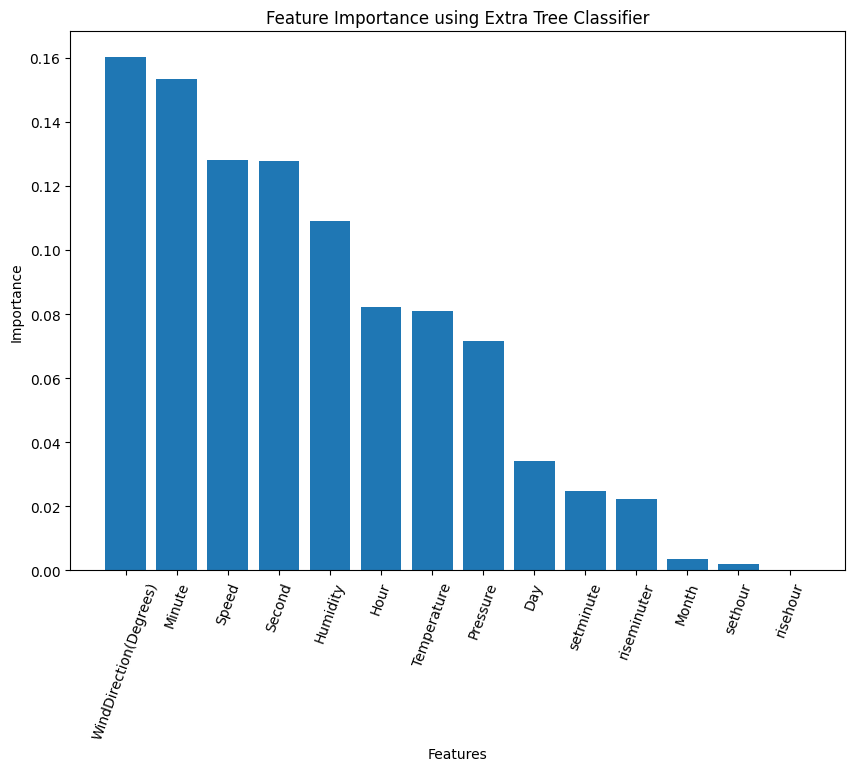

In [32]:
plt.figure(figsize=(10,7))
plt.bar(feature_importances.index,feature_importances['feature_imp'])
plt.xticks(rotation=70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Extra Tree Classifier')
plt.show()

# Feature Engineering with BoxCox,Log,Min-Max & Standard Transformation

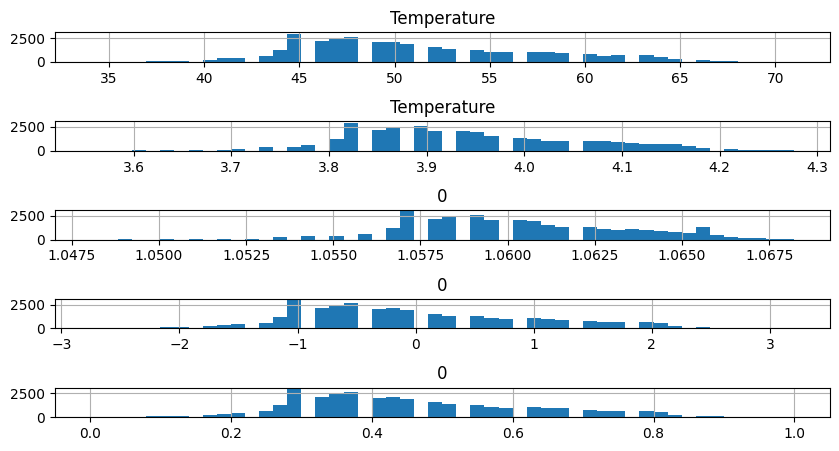

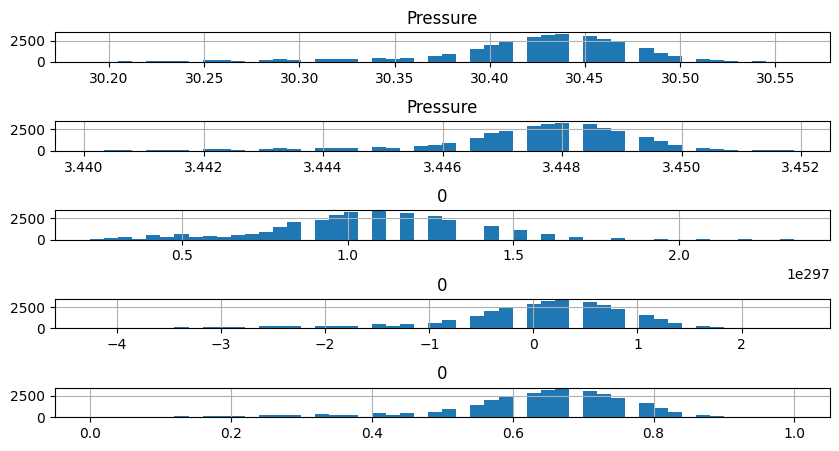

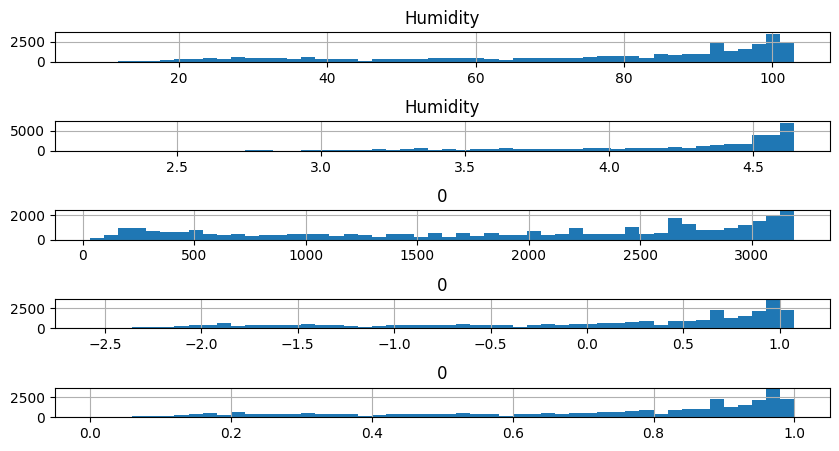

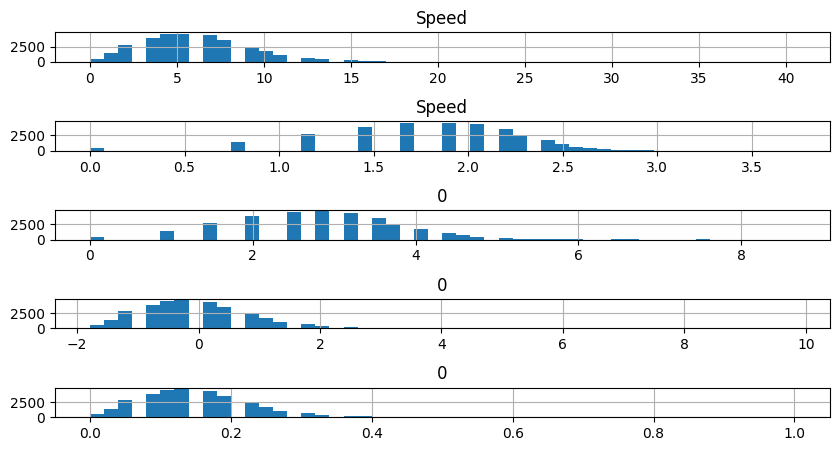

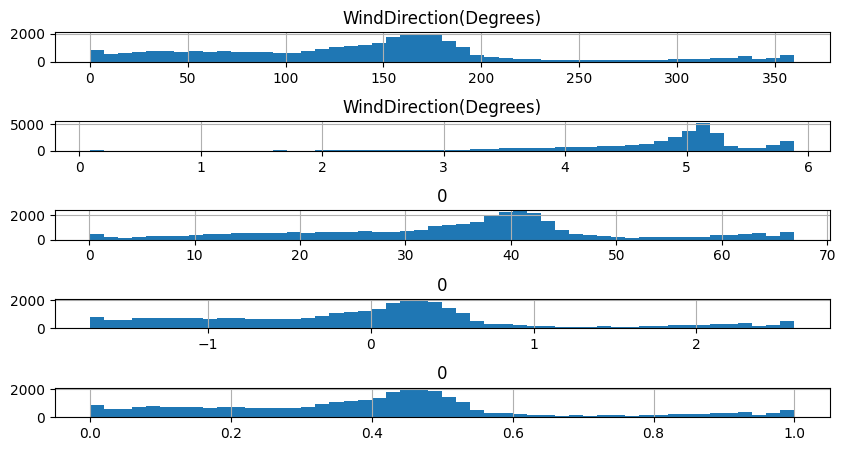

In [33]:
features_to_transform=['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']
for i in features_to_transform:
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(10,5))
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax5,bins=50)
    fig.subplots_adjust(hspace=2)

In [34]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
            'Speed' : (input_features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [35]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,1.245832e+297,1139.358393,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046718,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253293,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245832e+297,1175.187207,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245832e+297,1248.391911,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# Preparing data - Standardisation & Splitting

In [36]:
x_train, x_test, y_train, y_test =train_test_split(input_features,target,test_size=0.2,random_state=1)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# Model Comparison with Cross-Validation

In [37]:
# Handle NaN values that may result from transformations
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
x_train_clean = imputer.fit_transform(x_train)
x_test_clean = imputer.transform(x_test)

print("Data cleaning completed:")
print(f"Training set shape: {x_train_clean.shape}")
print(f"Test set shape: {x_test_clean.shape}")
print(f"NaN values in training set: {np.isnan(x_train_clean).sum()}")
print(f"NaN values in test set: {np.isnan(x_test_clean).sum()}")

Data cleaning completed:
Training set shape: (26148, 13)
Test set shape: (6538, 13)
NaN values in training set: 0
NaN values in test set: 0


In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold

# Store results for all models
results = []

# Define models
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'SVR': SVR(kernel='rbf', C=100, gamma='scale'),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=8, random_state=42)
}

# Setup cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
for model_name, model in models_dict.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, x_train_clean, y_train, cv=kfold, scoring='r2')
    
    # Train model on full training set
    model.fit(x_train_clean, y_train)
    
    # Make predictions
    y_pred_model = model.predict(x_test_clean)
    
    # Calculate metrics
    rmse_model = np.sqrt(mean_squared_error(y_test, y_pred_model))
    mae_model = median_absolute_error(y_test, y_pred_model)
    r2_model = r2_score(y_test, y_pred_model)
    
    # Store results
    results.append({
        'Model': model_name,
        'RMSE': rmse_model,
        'MAE': mae_model,
        'R² Score': r2_model,
        'CV Mean R²': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'CV Scores': cv_scores
    })
    
    print(f"\n{model_name}:")
    print(f"  RMSE: {rmse_model:.4f}")
    print(f"  MAE: {mae_model:.4f}")
    print(f"  R² Score: {r2_model:.4f}")
    print(f"  CV R² (Mean ± Std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Linear Regression:
  RMSE: 198.1841
  MAE: 126.1082
  R² Score: 0.5968
  CV R² (Mean ± Std): 0.6065 ± 0.0057

Ridge Regression:
  RMSE: 198.1838
  MAE: 126.2287
  R² Score: 0.5968
  CV R² (Mean ± Std): 0.6065 ± 0.0057

Lasso Regression:
  RMSE: 198.2018
  MAE: 126.1277
  R² Score: 0.5967
  CV R² (Mean ± Std): 0.6064 ± 0.0057

SVR:
  RMSE: 131.4347
  MAE: 24.0462
  R² Score: 0.8227
  CV R² (Mean ± Std): 0.8181 ± 0.0099

KNN (k=5):
  RMSE: 125.0812
  MAE: 6.6720
  R² Score: 0.8394
  CV R² (Mean ± Std): 0.8394 ± 0.0071

Random Forest:
  RMSE: 81.7730
  MAE: 0.2996
  R² Score: 0.9314
  CV R² (Mean ± Std): 0.9355 ± 0.0051

Gradient Boosting:
  RMSE: 105.9848
  MAE: 22.6960
  R² Score: 0.8847
  CV R² (Mean ± Std): 0.8835 ± 0.0068

XGBoost:
  RMSE: 82.9945
  MAE: 3.6095
  R² Score: 0.9293
  CV R² (Mean ± Std): 0.9334 ± 0.0046


In [39]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'RMSE': f"{r['RMSE']:.4f}",
        'MAE': f"{r['MAE']:.4f}",
        'R² Score': f"{r['R² Score']:.4f}",
        'CV Mean R²': f"{r['CV Mean R²']:.4f}",
        'CV Std': f"{r['CV Std']:.4f}"
    }
    for r in results
])

print("\n" + "="*100)
print("MODEL COMPARISON TABLE")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


MODEL COMPARISON TABLE
            Model     RMSE      MAE R² Score CV Mean R² CV Std
Linear Regression 198.1841 126.1082   0.5968     0.6065 0.0057
 Ridge Regression 198.1838 126.2287   0.5968     0.6065 0.0057
 Lasso Regression 198.2018 126.1277   0.5967     0.6064 0.0057
              SVR 131.4347  24.0462   0.8227     0.8181 0.0099
        KNN (k=5) 125.0812   6.6720   0.8394     0.8394 0.0071
    Random Forest  81.7730   0.2996   0.9314     0.9355 0.0051
Gradient Boosting 105.9848  22.6960   0.8847     0.8835 0.0068
          XGBoost  82.9945   3.6095   0.9293     0.9334 0.0046


In [40]:
# Find best model based on R² score
best_model_idx = max(range(len(results)), key=lambda i: results[i]['R² Score'])
best_model_info = results[best_model_idx]

print("\n" + "="*100)
print("BEST MODEL ANALYSIS")
print("="*100)
print(f"Best Model: {best_model_info['Model']}")
print(f"  • RMSE: {best_model_info['RMSE']:.4f}")
print(f"  • MAE: {best_model_info['MAE']:.4f}")
print(f"  • R² Score: {best_model_info['R² Score']:.4f}")
print(f"  • Cross-Validation R² (Mean): {best_model_info['CV Mean R²']:.4f}")
print(f"  • Cross-Validation R² (Std): {best_model_info['CV Std']:.4f}")
print(f"  • Individual CV Scores: {[f'{score:.4f}' for score in best_model_info['CV Scores']]}")
print("="*100)


BEST MODEL ANALYSIS
Best Model: Random Forest
  • RMSE: 81.7730
  • MAE: 0.2996
  • R² Score: 0.9314
  • Cross-Validation R² (Mean): 0.9355
  • Cross-Validation R² (Std): 0.0051
  • Individual CV Scores: ['0.9351', '0.9327', '0.9427', '0.9392', '0.9279']


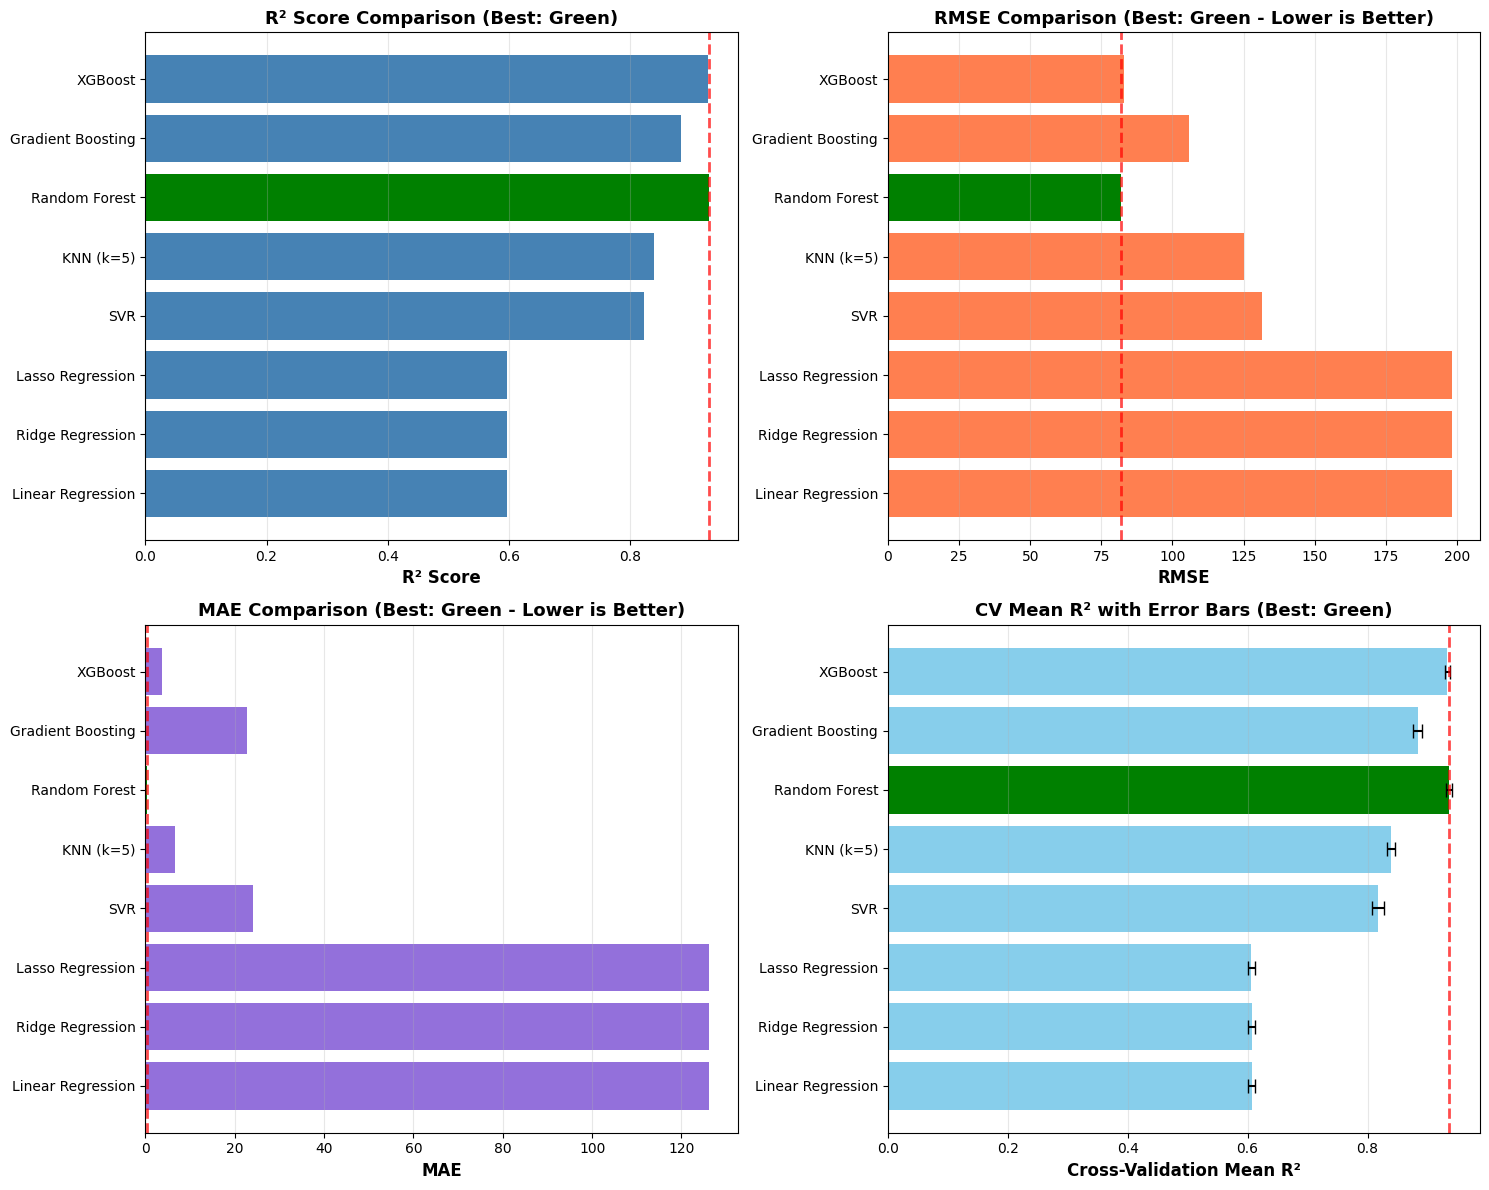

In [41]:
# Visualization 1: R² Score Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Score Comparison
ax1 = axes[0, 0]
models = [r['Model'] for r in results]
r2_scores = [r['R² Score'] for r in results]
colors = ['green' if r['R² Score'] == max(r2_scores) else 'steelblue' for r in results]
ax1.barh(models, r2_scores, color=colors)
ax1.set_xlabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score Comparison (Best: Green)', fontsize=13, fontweight='bold')
ax1.axvline(x=max(r2_scores), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.grid(axis='x', alpha=0.3)

# RMSE Comparison
ax2 = axes[0, 1]
rmse_scores = [r['RMSE'] for r in results]
colors_rmse = ['green' if r['RMSE'] == min(rmse_scores) else 'coral' for r in results]
ax2.barh(models, rmse_scores, color=colors_rmse)
ax2.set_xlabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Comparison (Best: Green - Lower is Better)', fontsize=13, fontweight='bold')
ax2.axvline(x=min(rmse_scores), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.grid(axis='x', alpha=0.3)

# MAE Comparison
ax3 = axes[1, 0]
mae_scores = [r['MAE'] for r in results]
colors_mae = ['green' if r['MAE'] == min(mae_scores) else 'mediumpurple' for r in results]
ax3.barh(models, mae_scores, color=colors_mae)
ax3.set_xlabel('MAE', fontsize=12, fontweight='bold')
ax3.set_title('MAE Comparison (Best: Green - Lower is Better)', fontsize=13, fontweight='bold')
ax3.axvline(x=min(mae_scores), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.grid(axis='x', alpha=0.3)

# Cross-Validation R² Comparison
ax4 = axes[1, 1]
cv_means = [r['CV Mean R²'] for r in results]
cv_stds = [r['CV Std'] for r in results]
colors_cv = ['green' if r['CV Mean R²'] == max(cv_means) else 'skyblue' for r in results]
ax4.barh(models, cv_means, xerr=cv_stds, color=colors_cv, capsize=5)
ax4.set_xlabel('Cross-Validation Mean R²', fontsize=12, fontweight='bold')
ax4.set_title('CV Mean R² with Error Bars (Best: Green)', fontsize=13, fontweight='bold')
ax4.axvline(x=max(cv_means), color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

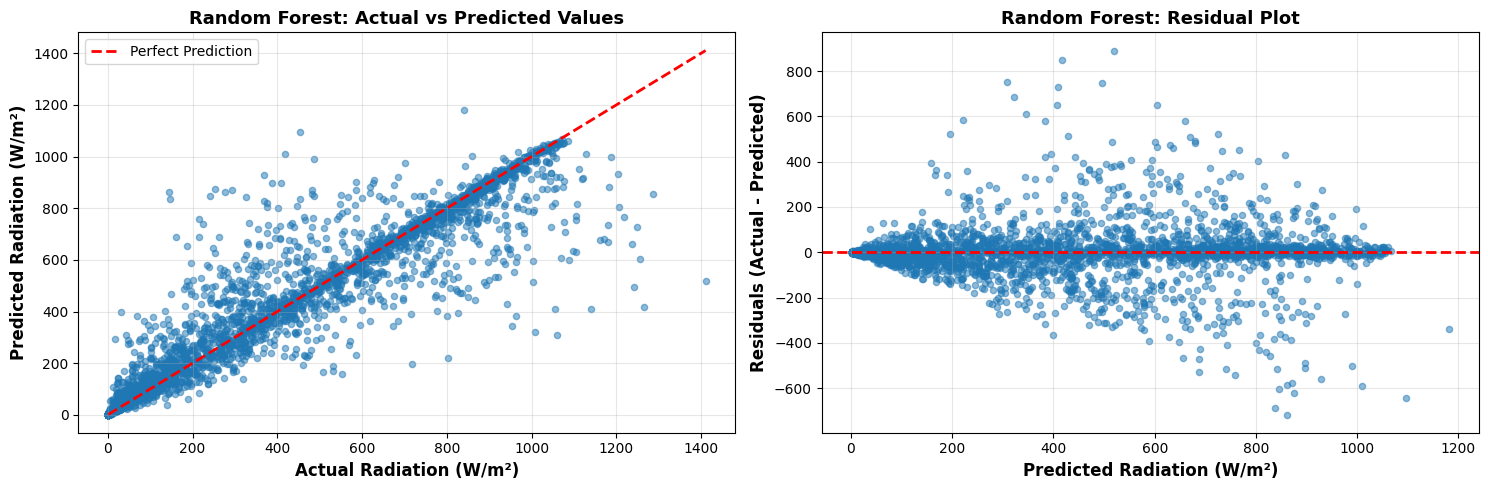

In [42]:
# Train best model and visualize predictions
best_model_name = best_model_info['Model']
best_model_obj = models_dict[best_model_name]
best_model_obj.fit(x_train, y_train)
best_y_pred = best_model_obj.predict(x_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted
ax1 = axes[0]
ax1.scatter(y_test, best_y_pred, alpha=0.5, s=20)
min_val = min(y_test.min(), best_y_pred.min())
max_val = max(y_test.max(), best_y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Radiation (W/m²)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Radiation (W/m²)', fontsize=12, fontweight='bold')
ax1.set_title(f'{best_model_name}: Actual vs Predicted Values', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Residuals
ax2 = axes[1]
residuals = y_test - best_y_pred
ax2.scatter(best_y_pred, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Radiation (W/m²)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
ax2.set_title(f'{best_model_name}: Residual Plot', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# Create Professional Presentation Table for Top 3 Models
top_3_models = sorted(results, key=lambda x: x['R² Score'], reverse=True)[:3]

top_3_data = []
for rank, model in enumerate(top_3_models, 1):
    top_3_data.append({
        'Rank': rank,
        'Model': model['Model'],
        'R² Score': f"{model['R² Score']:.4f}",
        'RMSE': f"{model['RMSE']:.2f}",
        'MAE': f"{model['MAE']:.4f}",
        'CV R² Mean': f"{model['CV Mean R²']:.4f}",
        'CV R² Std': f"{model['CV Std']:.4f}"
    })

top_3_df = pd.DataFrame(top_3_data)

# Display as styled table
print("\n" + "="*140)
print("TOP 3 BEST PERFORMING MODELS - PRESENTATION")
print("="*140)
print(top_3_df.to_string(index=False))
print("="*140)
print("\nMetrics Explanation:")
print("  • R² Score (Coefficient of Determination): Measures how well the model explains variance (higher is better, max=1.0)")
print("  • RMSE (Root Mean Squared Error): Average prediction error in watts/meter² (lower is better)")
print("  • MAE (Mean Absolute Error): Average absolute deviation of predictions (lower is better)")
print("  • CV R² Mean: Average cross-validation R² score across 5 folds (indicates generalization ability)")
print("  • CV R² Std: Standard deviation of CV scores (lower is better - indicates stability)")
print("="*140 + "\n")


TOP 3 BEST PERFORMING MODELS - PRESENTATION
 Rank             Model R² Score   RMSE     MAE CV R² Mean CV R² Std
    1     Random Forest   0.9314  81.77  0.2996     0.9355    0.0051
    2           XGBoost   0.9293  82.99  3.6095     0.9334    0.0046
    3 Gradient Boosting   0.8847 105.98 22.6960     0.8835    0.0068

Metrics Explanation:
  • R² Score (Coefficient of Determination): Measures how well the model explains variance (higher is better, max=1.0)
  • RMSE (Root Mean Squared Error): Average prediction error in watts/meter² (lower is better)
  • MAE (Mean Absolute Error): Average absolute deviation of predictions (lower is better)
  • CV R² Mean: Average cross-validation R² score across 5 folds (indicates generalization ability)
  • CV R² Std: Standard deviation of CV scores (lower is better - indicates stability)



In [45]:
import pickle

# Save the Random Forest model
rf_model = models_dict['Random Forest']
with open('model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Random Forest model saved as 'model.pkl'")

Random Forest model saved as 'model.pkl'
